In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 30
N_CUTS = 4
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('1992-04-09', datetime.date(2022, 4, 10))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


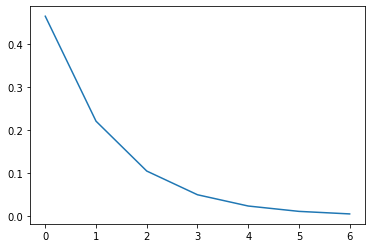

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.46566128730773904

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = [
    '^GSPC', # S&P 500
    '^IXIC', # Nasdaq
    '^NYA',  # NY Stock Exchange (total)
    '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [
    (first, second)
    for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
    for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-04-04  20.751611  8.175625  20.751611  8.175625  20.751611  8.175625   
2022-04-05  20.011166  7.902315  20.011166  7.902315  20.011166  7.902315   
2022-04-06  19.281924  7.588986  19.281924  7.588986  19.281924  7.588986   
2022-04-07  19.160761  7.575626  19.160761  7.575626  19.160761  7.575626   
2022-04-08  18.732501  7.354080  18.732501  7.354080  18.732501  7.354080   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-04-04  20.751611  8.175625  20.751611  8.175625  
2022-04-05  20.011166  7.902315  20.011166  7.902315  
2022-04-06  19.281924  7.588986  19.281924  7.588986  
2022-04-07  19.160761  7.575626  19.160761  7.575626  
2022-04-08  18.732501  7.354080  18.732501  7.354080

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                                             Close              \
        ^GSPC       ^IXIC         ^NYA       ^W5000       ^GSPC       ^IXIC   
0  400.640015  586.750000  2337.850098  3907.320068  400.640015  586.750000   
1  404.290009  584.239990  2360.800049  3941.419922  404.290009  584.239990   
2  406.079987  588.150024  2370.209961  3957.179932  406.079987  588.150024   
3  412.390015  594.809998  2403.510010  4010.580078  412.390015  594.809998   
4  416.279999  600.030029  2422.969971  4044.239990  416.279999  600.030029   

                                   High              ... DayToDayChange  \
          ^NYA       ^W5000       ^GSPC       ^IXIC  ...         ^W5000   
0  2337.850098  3907.320068  401.040009  586.750000  ...            NaN   
1  2360.800049  3941.419922  405.119995  592.239990  ...       1.008727   
2  2370.209961  3957.179932  406.079987  588.150024  ...       1.003999   
3  2403.510010  4010.580078  413.859985  597.789978  ...       1.013494   
4  2422.969971  4044.239990  416.279999  600.609985  ...       1.008393   

  OvernightChange LogValue IntradayChange DayToDayChange OvernightChange  \
           ^W5000    mine1          mine1          mine1           mine1   
0             NaN      NaN            NaN            NaN             NaN   
1        1.008727      NaN            NaN            NaN             NaN   
2        1.003999      NaN            NaN            NaN             NaN   
3        1.013494      NaN            NaN            NaN             NaN   
4        1.008393      NaN            NaN            NaN             NaN   

  LogValue IntradayChange DayToDayChange OvernightChange  
     mine2          mine2          mine2           mine2  
0      NaN            NaN            NaN             NaN  
1      NaN            NaN            NaN             NaN  
2      NaN            NaN            NaN             NaN  
3      NaN            NaN            NaN             NaN  
4      NaN            NaN            NaN             NaN  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

7552   2022-04-04
7553   2022-04-05
7554   2022-04-06
7555   2022-04-07
7556   2022-04-08
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                                             Close  \
                 ^GSPC       ^IXIC         ^NYA       ^W5000       ^GSPC   
Date                                                                       
1992-04-09  400.640015  586.750000  2337.850098  3907.320068  400.640015   
1992-04-10  404.290009  584.239990  2360.800049  3941.419922  404.290009   
1992-04-13  406.079987  588.150024  2370.209961  3957.179932  406.079987   
1992-04-14  412.390015  594.809998  2403.510010  4010.580078  412.390015   
1992-04-15  416.279999  600.030029  2422.969971  4044.239990  416.279999   

                                                        High              ...  \
                 ^IXIC         ^NYA       ^W5000       ^GSPC       ^IXIC  ...   
Date                                                                      ...   
1992-04-09  586.750000  2337.850098  3907.320068  401.040009  586.750000  ...   
1992-04-10  584.239990  2360.800049  3941.419922  405.119995  592.239990  ...   
1992-04-13  588.150024  2370.209961  3957.179932  406.079987  588.150024  ...   
1992-04-14  594.809998  2403.510010  4010.580078  413.859985  597.789978  ...   
1992-04-15  600.030029  2422.969971  4044.239990  416.279999  600.609985  ...   

           DayToDayChange OvernightChange LogValue IntradayChange  \
                   ^W5000          ^W5000    mine1          mine1   
Date                                                                
1992-04-09            NaN             NaN      NaN            NaN   
1992-04-10       1.008727        1.008727      NaN            NaN   
1992-04-13       1.003999        1.003999      NaN            NaN   
1992-04-14       1.013494        1.013494      NaN            NaN   
1992-04-15       1.008393        1.008393      NaN            NaN   

           DayToDayChange OvernightChange LogValue IntradayChange  \
                    mine1           mine1    mine2          mine2   
Date                                                                
1992-04-09            NaN             NaN      NaN            NaN   
1992-04-10            NaN             NaN      NaN            NaN   
1992-04-13            NaN             NaN      NaN            NaN   
1992-04-14            NaN             NaN      NaN            NaN   
1992-04-15            NaN             NaN      NaN            NaN   

           DayToDayChange OvernightChange  
                    mine2           mine2  
Date                                       
1992-04-09            NaN             NaN  
1992-04-10            NaN             NaN  
1992-04-13            NaN             NaN  
1992-04-14            NaN             NaN  
1992-04-15            NaN             NaN  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(
            f'Unexpected error getting {stock} data. Initialized as '
            f'None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'w') as f:
        json.dump(best_param_set, f)

In [20]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.46566128730773904



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.007356850404823
Refitting current best...
Current best ma returns: 4.584178467806426
Fraction Invested: 0.9940203410339293
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 4.5879616410345525
Invested: 0.9940203410339293
New best: 4.600909829827114
Invested: 0.996471558724419
New best: 4.60937934652871
Invested: 0.9980725285748848
New best: 4.618991944713718
Invested: 0.9998872886344835
New best: 4.6272711301467995
Invested: 0.9998872886344835
New best: 4.628245045775622
Invested: 0.9998872886344835
New best: 4.84291148886906
Invested: 0.9998872886344835
New best: 4.8618950380883295
Invested: 0.9998872886344835
Round: 180


Beginning ew_ma

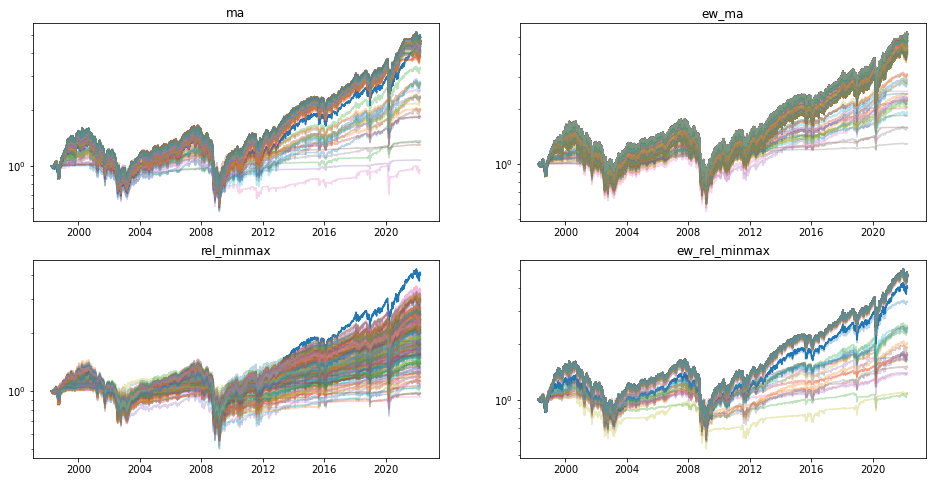

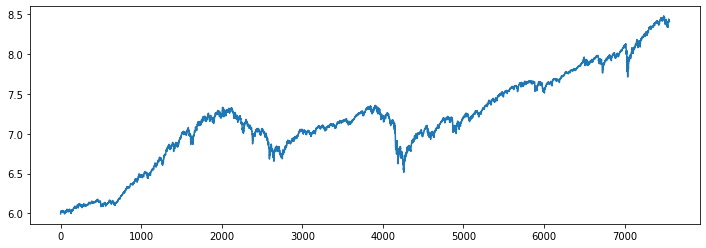

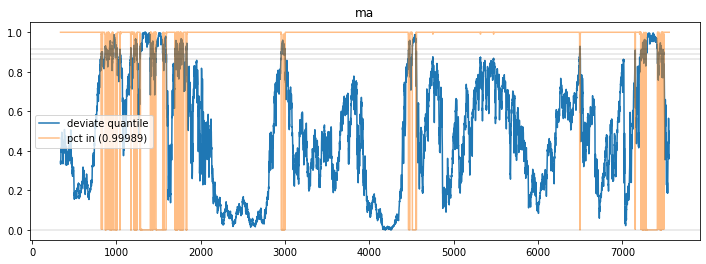

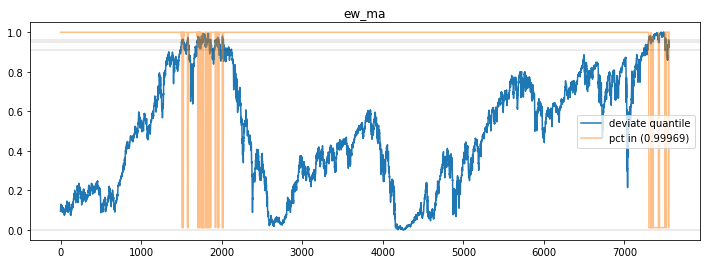

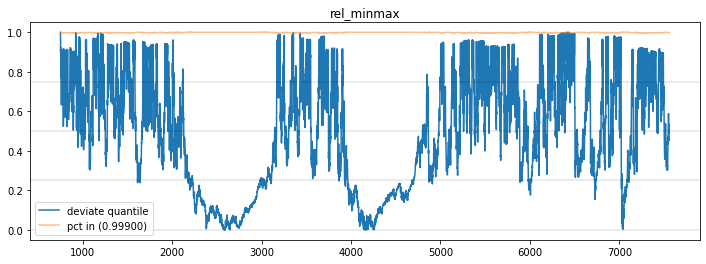

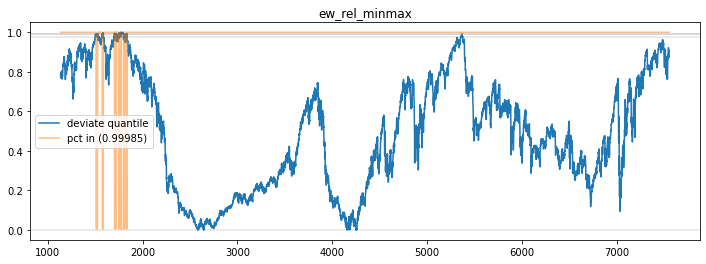

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 7.3995122879303645
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 7.3995122879303645
Refitting current best...
Current best ew_ma returns: 9.448972674241405
Fraction Invested: 0.9999752327605425
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 9.449101658977053
Invested: 0.9999752327605425
New best: 9.45065199594399
Invested: 0.9999752327605425
New best: 9.451203323078886
Invested: 0.9999752327605425
Round: 180


Beginning rel_minmax 

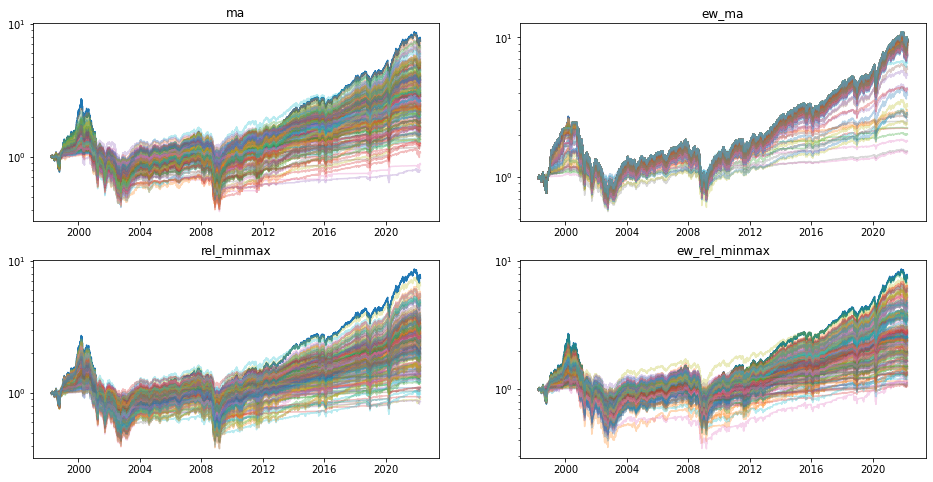

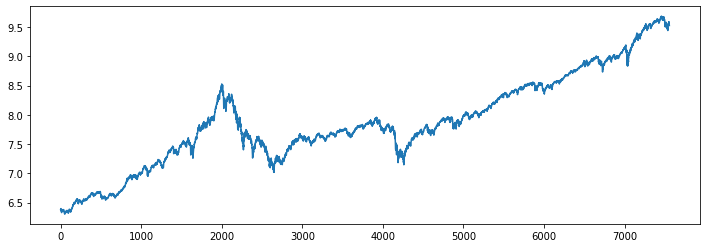

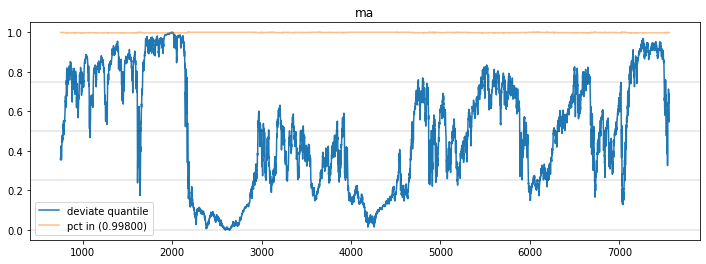

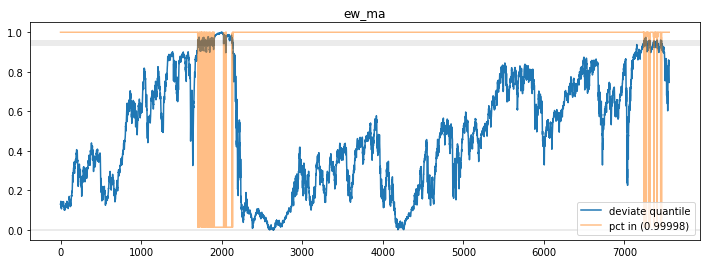

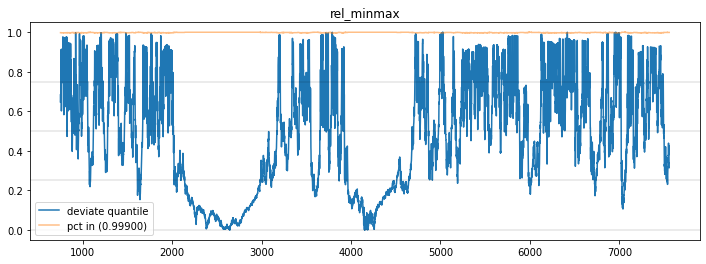

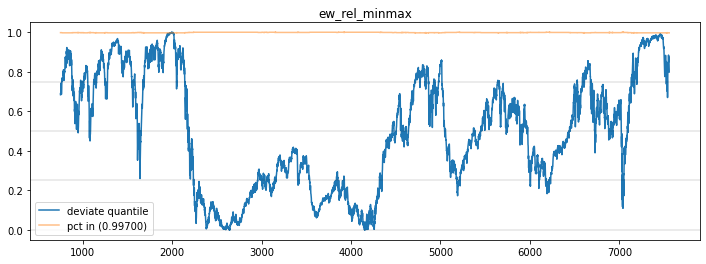

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.7119034902064953
Refitting current best...
Current best ma returns: 3.9020062592240348
Fraction Invested: 0.9954987587613537
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 3.9061151437605943
Invested: 0.9954987587613537
New best: 3.908736852175744
Invested: 0.9954987587613537
New best: 3.920346818483994
Invested: 0.9954987587613537
New best: 3.920362280300298
Invested: 0.9954987587613537
New best: 3.9204207585621074
Invested: 0.9954987587613537
New best: 3.932057958569949
Invested: 0.9979192743392202
New best: 3.9644740482054743
Invested: 0.9979192743392202
Round: 180


Beginning ew_ma method...
-------------------------------------------

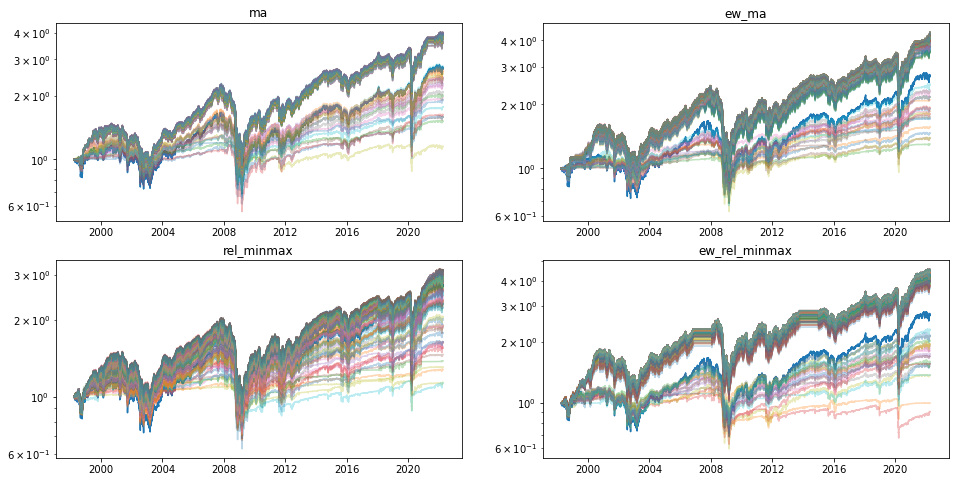

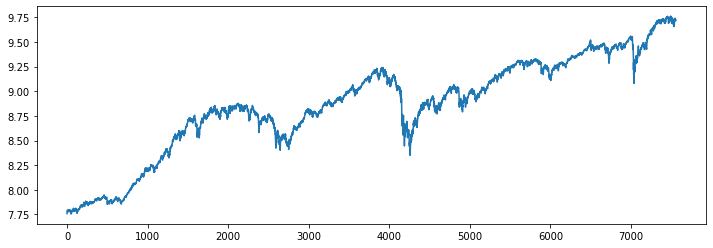

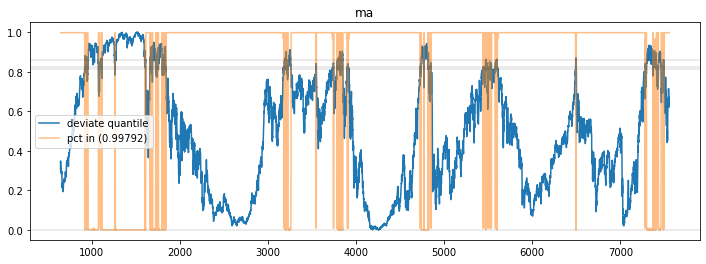

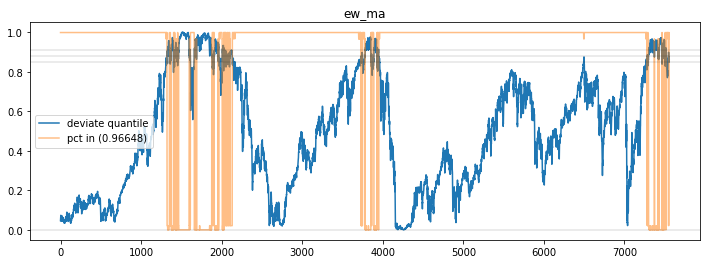

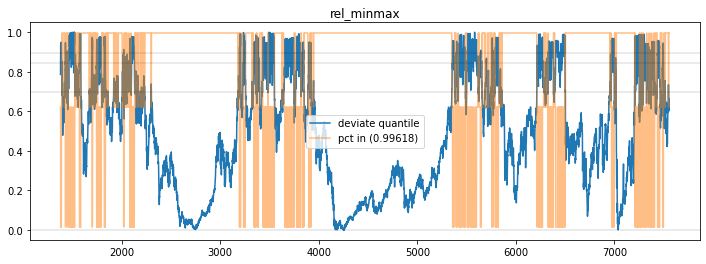

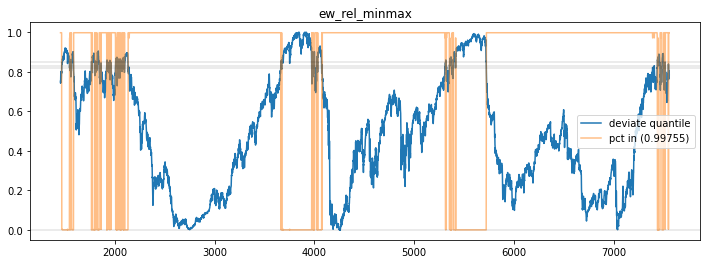

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.2174263349744745
Refitting current best...
Current best ma returns: 6.157456821530562
Fraction Invested: 0.9994559161045942
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 6.160920350074039
Invested: 0.9999223241921549
New best: 6.162124822940973
Invested: 0.9999223241921549
New best: 6.162709965981109
Invested: 0.9999223241921549
New best: 6.162715295931487
Invested: 0.9999223241921549
New best: 6.163060461452808
Invested: 0.99996878235621
New best: 6.163170434310536
Invested: 0.99996878235621
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.2174263349744745
Refitting current

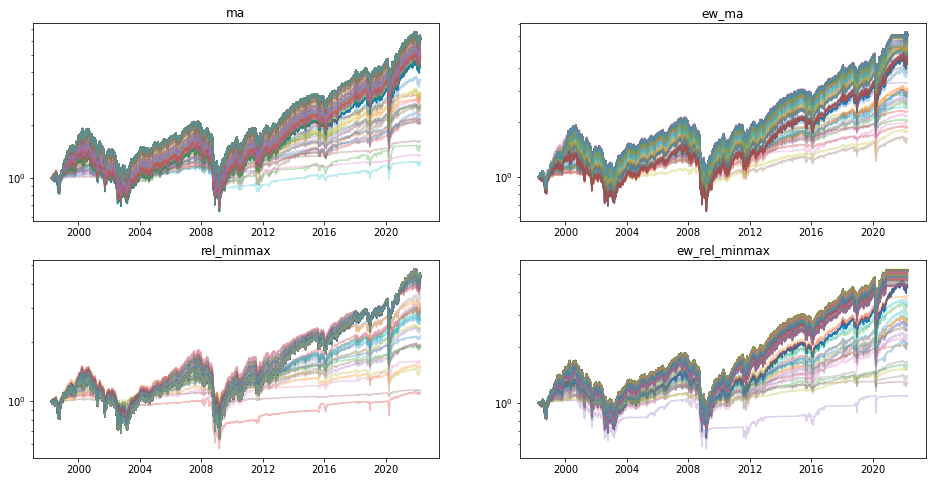

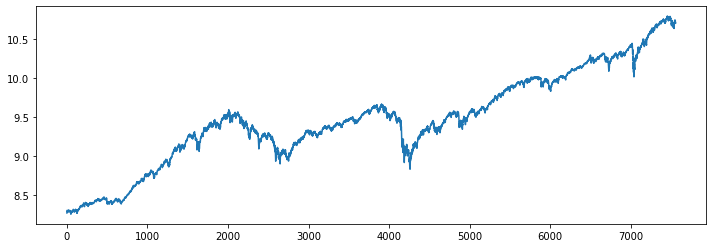

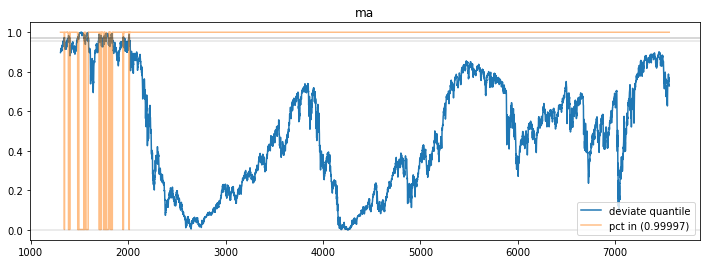

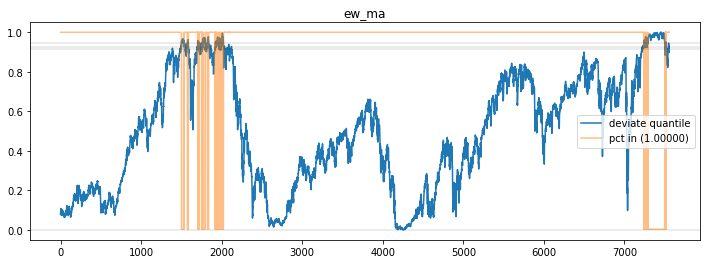

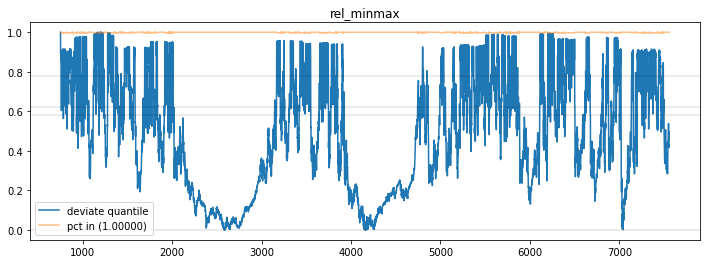

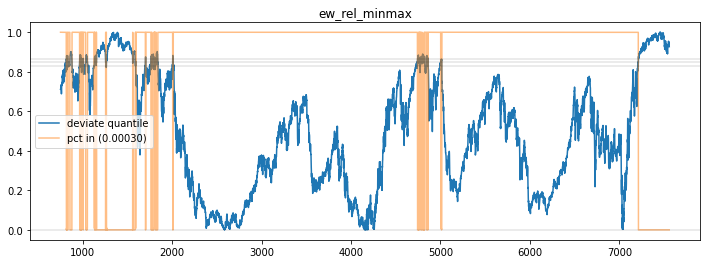

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 13.470615197086508
Refitting current best...
Current best ma returns: 15.14541772859909
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 13.470615197086508
Refitting current best...
Current best ew_ma returns: 16.041147511853268
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 16.074521978335653
Invested: 1.0
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 13.470615197086508
Refitting current best...
Curr

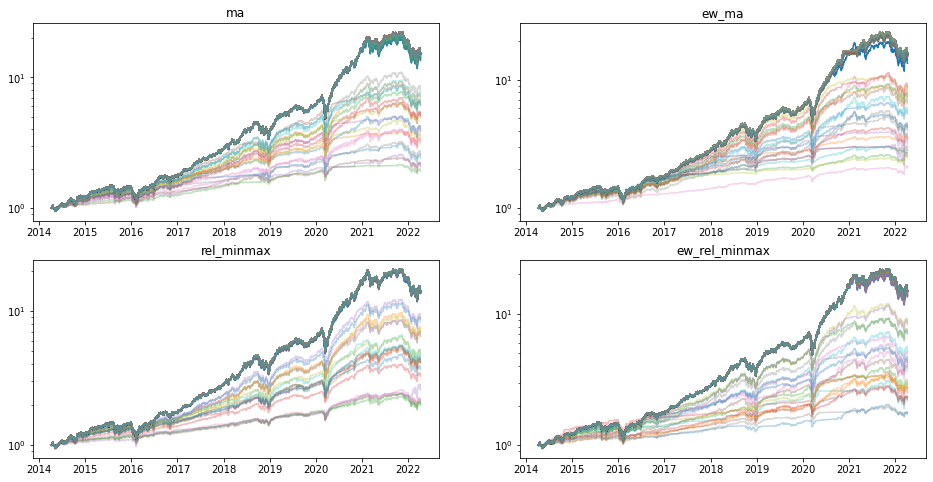

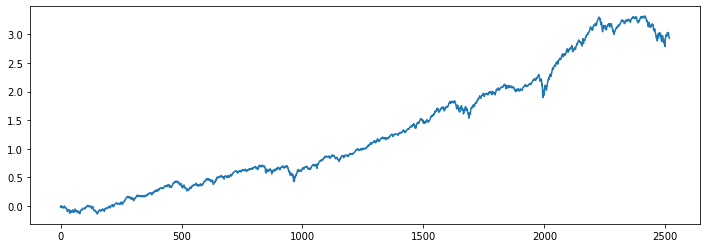

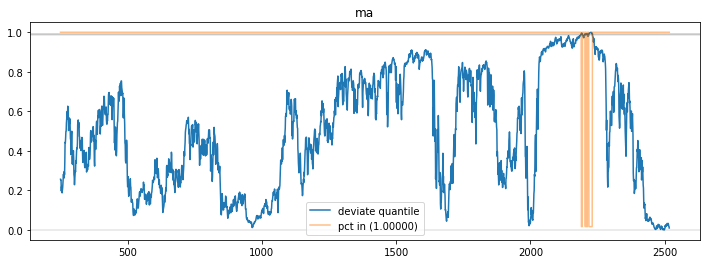

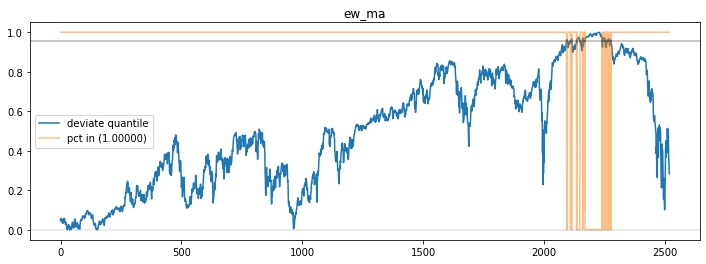

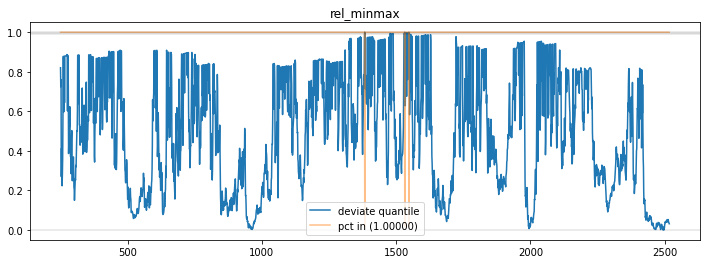

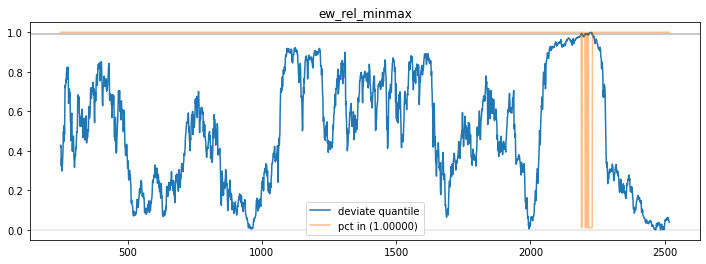

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 5.293621034351199
Refitting current best...
Current best ma returns: 7.032113160557147
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 7.032116441220392
Invested: 1.0
New best: 7.034276547491233
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 5.293621034351199
Refitting current best...
Current best ew_ma returns: 6.916914566792303
Fraction Invested: 0.9999764342584916
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 6.922762717349594
Invested: 0.9999764342584916
New best: 6.928040558676548
Invested: 0.999976434258491

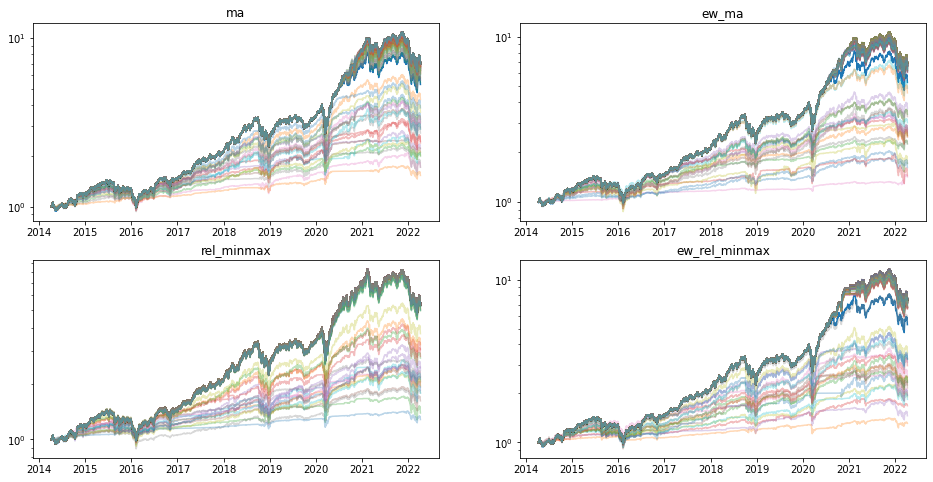

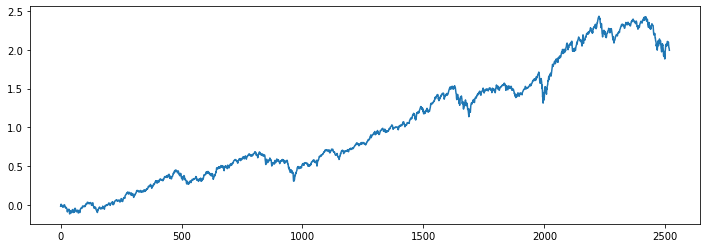

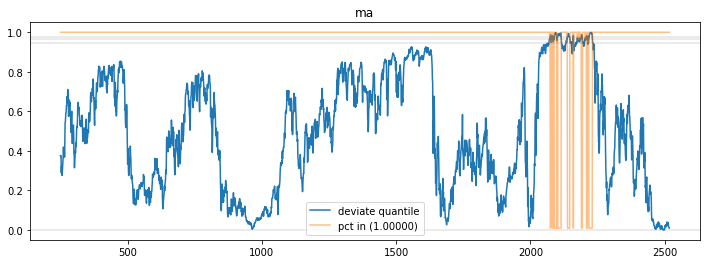

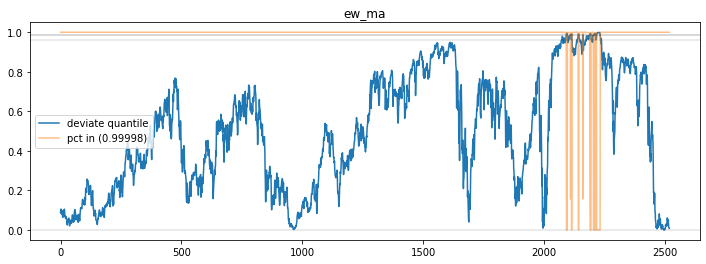

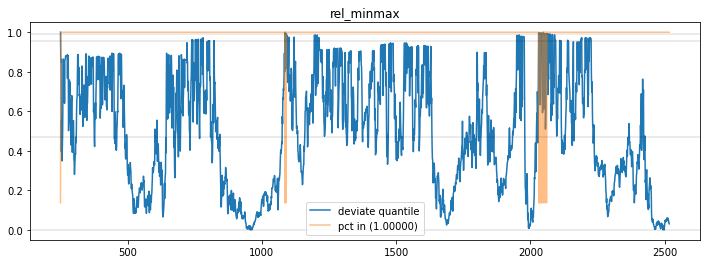

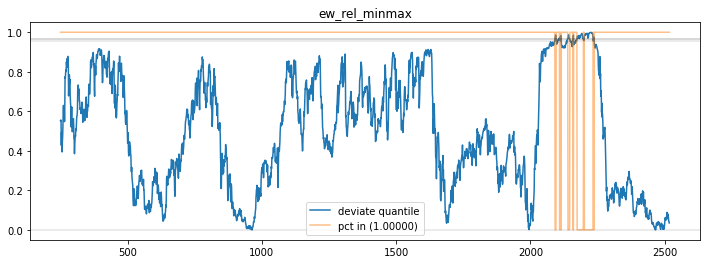

Saving mine2 params...


In [51]:
#N_RAND = 20
#N_ADJ = 180

N_RAND = 5
N_ADJ = 45

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(
            stock_data, 
            N_CUTS, 
            best_param_set=best_params, 
            best_returns=best_returns, 
            sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [62]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = {'best_return': best_return, 'pct_in': best_pct}
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [63]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 5.176548082752048 (ew_ma)
  0.99969329 in
time param: 811
qs:
(0.0000 - 0.9095): 1.0000
(0.9095 - 0.9490): 0.9997
(0.9490 - 0.9607): 0.9777
(0.9607 - 1.0000): 0.0115

^IXIC:
  Best Return: 9.451203323078886 (ew_ma)
  0.99997523 in
time param: 435
qs:
(0.0000 - 0.9379): 1.0000
(0.9379 - 0.9432): 0.9981
(0.9432 - 0.9550): 0.9763
(0.9550 - 1.0000): 0.0137

^NYA:
  Best Return: 4.491127982595787 (ew_rel_minmax)
  0.99755418 in
time param: 1458
qs:
(0.0000 - 0.8173): 0.9976
(0.8173 - 0.8317): 0.9714
(0.8317 - 0.8510): 0.0036
(0.8510 - 1.0000): 0.0002

^W5000:
  Best Return: 6.163170434310536 (ma)
  0.99996878 in
time param: 1307
qs:
(0.0000 - 0.9561): 1.0000
(0.9561 - 0.9703): 0.9985
(0.9703 - 0.9705): 0.9827
(0.9705 - 1.0000): 0.0023

mine1:
  Best Return: 16.074521978335653 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9565): 1.0000
(0.9565 - 0.9566): 0.9627
(0.9566 - 0.9568): 0.0996
(0.9568 - 1.0000): 0.0007

mine2:
  Best Return: 7.530811285645173 (ew_re

{'^GSPC': {'best_return': 5.176548082752048, 'pct_in': 0.9996932886072432},
 '^IXIC': {'best_return': 9.451203323078886, 'pct_in': 0.9999752327605425},
 '^NYA': {'best_return': 4.491127982595787, 'pct_in': 0.9975541759921893},
 '^W5000': {'best_return': 6.163170434310536, 'pct_in': 0.99996878235621},
 'mine1': {'best_return': 16.074521978335653, 'pct_in': 1.0},
 'mine2': {'best_return': 7.530811285645173, 'pct_in': 1.0}}

In [64]:
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]['best_return']
    den = do_nothing_returns[stock]
    weight = num / den
    if weight <= 1:
        weight = 0
    if stock.startswith('mine'):
        weight /= 2
    best_returns[stock]['weight'] = weight
best_returns

{'^GSPC': {'best_return': 5.176548082752048,
  'pct_in': 0.9996932886072432,
  'weight': 1.2917611972163432},
 '^IXIC': {'best_return': 9.451203323078886,
  'pct_in': 0.9999752327605425,
  'weight': 1.2772738195860713},
 '^NYA': {'best_return': 4.491127982595787,
  'pct_in': 0.9975541759921893,
  'weight': 1.6560795761407474},
 '^W5000': {'best_return': 6.163170434310536,
  'pct_in': 0.99996878235621,
  'weight': 1.4613581707877863},
 'mine1': {'best_return': 16.074521978335653,
  'pct_in': 1.0,
  'weight': 0.5966513682987667},
 'mine2': {'best_return': 7.530811285645173,
  'pct_in': 1.0,
  'weight': 0.7113100122559274}}

In [65]:
with open(f'{DATA}/qp_{N_YEARS}_weights.json', 'w') as f:
    json.dump(best_returns, f)

In [66]:
!say qp is dunzo